In [13]:
import MDAnalysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
file_path = "/home/debian/water/TIP4P/2005/2020/dump_H2O_225.lammpstrj"


In [15]:
u = MDAnalysis.Universe(file_path, format="LAMMPSDUMP")

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [16]:
from MDAnalysis.lib.nsgrid import FastNS

观察66号原子的第2000帧的邻居信息，设置截距在3.7埃

In [29]:
target_idx = 15
frame_idx = 2000
cutoff = 3.7  # in Angstroms

In [30]:
u.trajectory[frame_idx]
target_atom = u.atoms[target_idx]
O_atoms = u.select_atoms("type 1")
ns = FastNS(cutoff, O_atoms.positions, u.dimensions)
results = ns.self_search()

In [31]:
pair_indices = results.get_pairs()
print(pair_indices)
# 找到最小的编号和最大的编号
min_idx = np.min(pair_indices)
max_idx = np.max(pair_indices)
print(min_idx, max_idx)

[[3672 2908]
 [3672 3074]
 [3672 3371]
 ...
 [ 859 1276]
 [ 719 2354]
 [3756 1129]]
0 4095


In [32]:
print(f"Neighbors of atom {target_idx} at frame {frame_idx} within {cutoff} Å:")
for pair in results.get_pairs():
    if target_idx in pair:
        neighbor_idx = pair[1] if pair[0] == target_idx else pair[0]
        distance = np.linalg.norm(O_atoms.positions[target_idx] - O_atoms.positions[neighbor_idx])
        print(f"Atom {neighbor_idx} at distance {distance:.2f} Å")

Neighbors of atom 15 at frame 2000 within 3.7 Å:
Atom 3359 at distance 51.49 Å
Atom 4021 at distance 52.60 Å
Atom 3924 at distance 52.86 Å
Atom 2656 at distance 69.43 Å


In [33]:
# apply_PBC
from MDAnalysis.lib.distances import apply_PBC

In [34]:
for pair, distance in zip(results.get_pairs(), results.get_pair_distances()):
    if target_idx in pair:
        neighbor_idx = pair[1] if pair[0] == target_idx else pair[0]
        if distance <= 3.5:
            print(f"Atom {neighbor_idx} at distance {distance:.2f} Å (using apply_PBC)")

Atom 3359 at distance 2.85 Å (using apply_PBC)
Atom 4021 at distance 2.72 Å (using apply_PBC)
Atom 3924 at distance 3.08 Å (using apply_PBC)
Atom 2656 at distance 2.74 Å (using apply_PBC)


观察该水分子的周围环境，进行可视化

In [13]:
neighbor_idxs = []
for pair in results.get_pairs():
    if target_idx in pair:
        neighbor_idx = pair[1] if pair[0] == target_idx else pair[0]
        neighbor_idxs.append(neighbor_idx)

# 观察该水分子的周围环境，进行可视化
neighbor_positions = u.atoms[neighbor_idxs].positions
target_position = target_atom.position

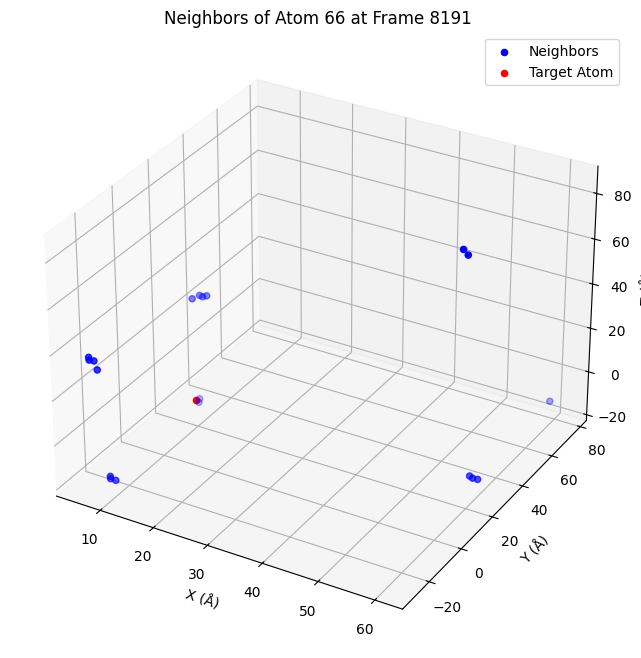

In [18]:
# unwrapped positions展示
fig= plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(neighbor_positions[:, 0], neighbor_positions[:, 1], neighbor_positions[:, 2], c='b', label='Neighbors')
ax.scatter(target_position[0], target_position[1], target_position[2], c='r', label='Target Atom')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title(f'Neighbors of Atom {target_idx} at Frame {frame_idx}')
ax.legend()
plt.show()

In [15]:
# wrapped positions展示
wrapped_positions = apply_PBC(neighbor_positions, u.dimensions)
wrapped_target_position = apply_PBC(target_position, u.dimensions)

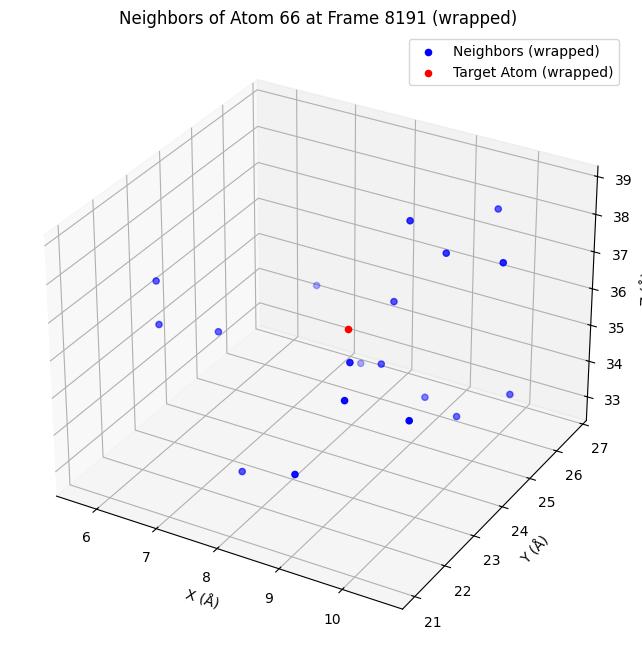

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wrapped_positions[:, 0], wrapped_positions[:, 1], wrapped_positions[:, 2], c='b', label='Neighbors (wrapped)')
ax.scatter(wrapped_target_position[0], wrapped_target_position[1], wrapped_target_position[2], c='r', label='Target Atom (wrapped)')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title(f'Neighbors of Atom {target_idx} at Frame {frame_idx} (wrapped)')
ax.legend()
plt.show()

In [23]:
# 展示与最近像原子的位置关系
dimensions = u.dimensions
for neighbor_idx, neighbor_pos in zip(neighbor_idxs, wrapped_positions):
    delta = wrapped_target_position - neighbor_pos
    print(f"Checking atom {neighbor_idx}: delta = {delta}")
    print(f"distance = {np.linalg.norm(delta)}")
    if np.any(np.abs(delta) > dimensions[:3] / 2):
        print(f"Atom {neighbor_idx} is closer in a periodic image.")
        image_shift = np.round(delta / dimensions[:3]) * dimensions[:3]
        actual_position = neighbor_pos + image_shift
        print(f"Actual position considering PBC: {actual_position}")

Checking atom 6352: delta = [0.7234392 2.0503006 2.7552986]
distance = 3.509810209274292
Checking atom 10135: delta = [ 2.5940294  1.1585999 -0.8832016]
distance = 2.975128173828125
Checking atom 10134: delta = [2.4070692  1.4413013  0.01200104]
distance = 2.805614948272705
Checking atom 8334: delta = [ 0.8106489 -2.1091995  2.8680992]
distance = 3.651283025741577
Checking atom 6100: delta = [ 1.7264471 -2.411501   1.2877998]
distance = 3.2333240509033203
Checking atom 10136: delta = [1.7367492  0.83180046 0.32099915]
distance = 1.9522371292114258
Checking atom 11942: delta = [-0.7804003  3.2938995  1.0788002]
distance = 3.5528311729431152
Checking atom 290: delta = [-0.8740597   1.7349014  -0.75370026]
distance = 2.0837292671203613
Checking atom 289: delta = [-2.1521502   2.4689999  -0.40810013]
distance = 3.300644636154175
Checking atom 288: delta = [-1.2185001   2.6082     -0.56679916]
distance = 2.934060573577881
Checking atom 7601: delta = [-2.0539503 -1.2818012  1.7327995]
distan

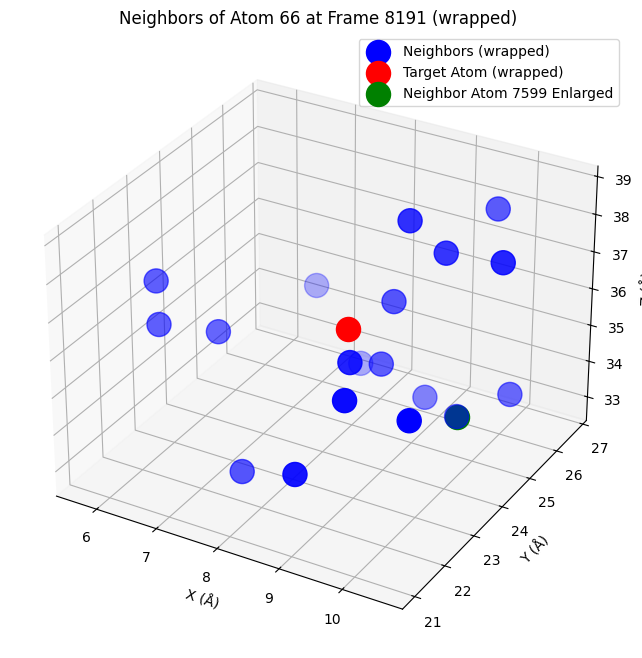

In [26]:
# 增加氧原子半径大小的可视化， 按照实际比例展示，一个氧原子大约0.66Å，对应图中的表示大小参数应该为300
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wrapped_positions[:, 0], wrapped_positions[:, 1], wrapped_positions[:, 2], s=300, c='b', label='Neighbors (wrapped)')
ax.scatter(wrapped_target_position[0], wrapped_target_position[1], wrapped_target_position[2], s=300, c='r', label='Target Atom (wrapped)')
ax.scatter(wrapped_positions[12, 0], wrapped_positions[12, 1], wrapped_positions[12, 2], s=300, c='g', label=f'Neighbor Atom {neighbor_idxs[12]} Enlarged')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title(f'Neighbors of Atom {target_idx} at Frame {frame_idx} (wrapped)')
ax.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

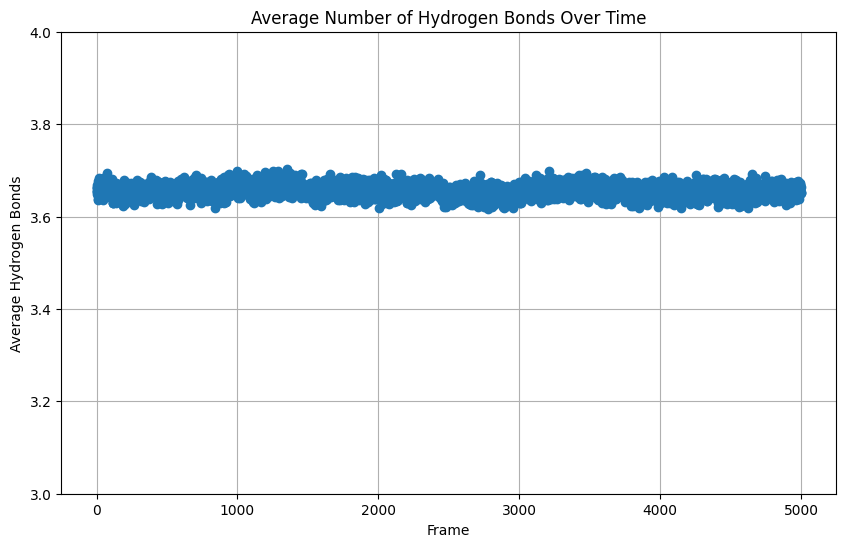

In [4]:
# 绘制氢键数量随时间变化的图表
data = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/equili/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

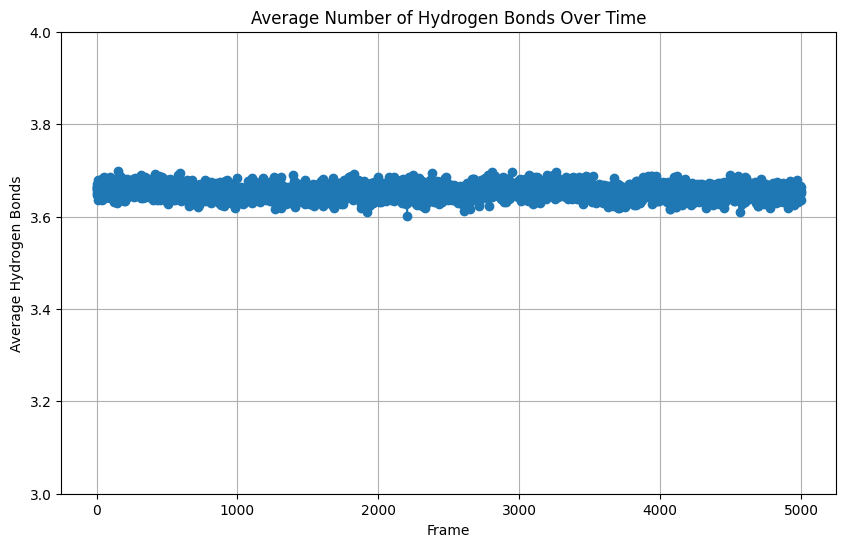

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/1e-7/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

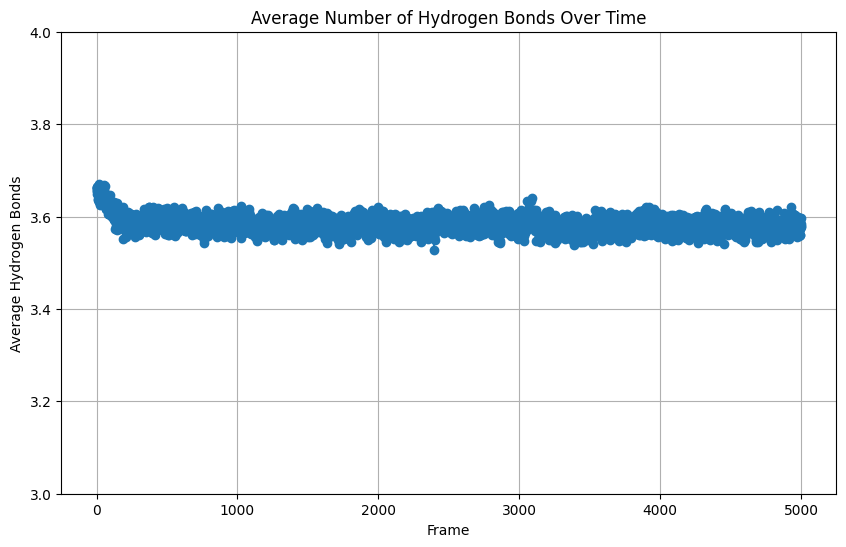

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/1e-5/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

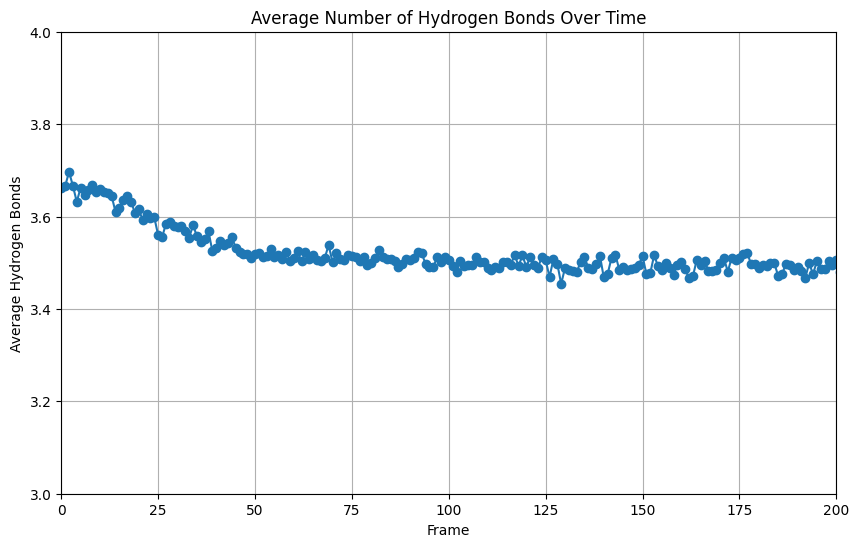

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/5e-5/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.xlim(0,200)
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

zeta = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/equili/zeta.csv",names=["frame","O_idx","distance"], header=0)
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

zeta_test.shape at frame 5000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 12
zeta_test.shape at frame 0: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 22
zeta_test.shape at frame 1000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 15
zeta_test.shape at frame 2000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 11
zeta_test.shape at frame 3000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 12
zeta_test.shape at frame 4000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 15


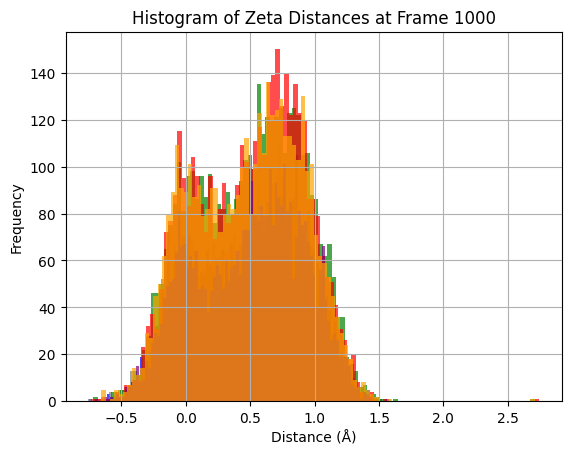

In [ ]:
zeta_test = zeta[zeta["frame"] == 5000]
print(f"zeta_test.shape at frame 5000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 5000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False,color='blue', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 0]
print(f"zeta_test.shape at frame 0: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 0: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='gray', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 1000]
print(f"zeta_test.shape at frame 1000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 1000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='green', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 2000]
print(f"zeta_test.shape at frame 2000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 2000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='red', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 3000]
print(f"zeta_test.shape at frame 3000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 3000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='purple', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 4000]
print(f"zeta_test.shape at frame 4000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 4000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False,color='orange', alpha=0.7)
plt.title('Histogram of Zeta Distances at Frame 1000')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
data_x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
data_y = np.array([8,4,3,3,4,1,3,2,2,1])
def func(p,x,y):
    return p[0] * np.exp(-x/p[1]) + p[2] - y
# 使用data对func进行拟合
p0 = [13,1.2, 2.1]
from scipy.optimize import leastsq
ret = leastsq(func, p0, args=(data_x, data_y))
print(ret)


(array([13.66364051,  1.14937173,  2.11504757]), 1)


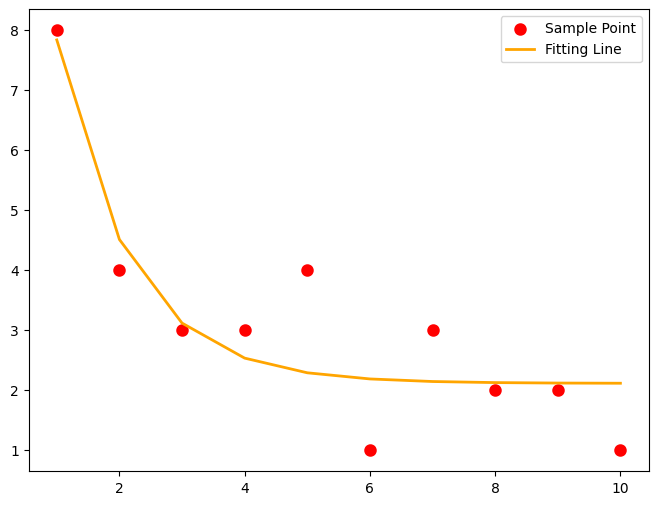

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(data_x,data_y,color="red",label="Sample Point",linewidth=3)
def f(p, x):
    return p[0] * np.exp(-x/p[1]) + p[2]

y = f(ret[0], data_x)

plt.plot(data_x,y,color="orange",label="Fitting Line",linewidth=2)
plt.legend()
plt.show()  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

In [4]:
zeta_file = "/home/debian/water/TIP4P/2005/nvt/rst/equili/zeta.csv"

In [5]:
zeta = pd.read_csv(zeta_file, names=["frame", "O_idx", "distance"],
        header=0)

Silverman带宽: 0.012988


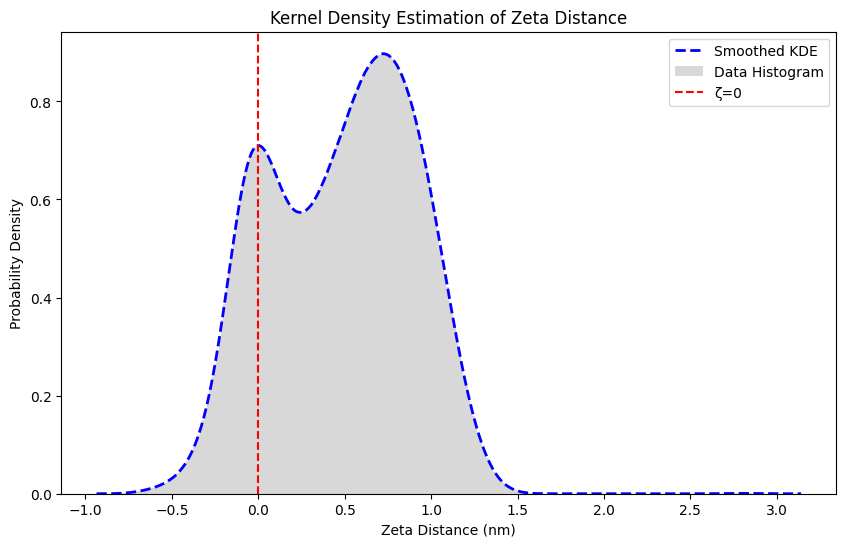

In [7]:
from scipy.stats import gaussian_kde
from scipy.stats import iqr
from scipy.signal import savgol_filter

data = zeta["distance"].values
n = len(data)
        # 使用Silverman法则计算最优带宽
silverman_bandwidth = 0.9 * min(np.std(data), iqr(data) / 1.34) * n ** (-0.2)
print(f"Silverman带宽: {silverman_bandwidth:.6f}")
        # 使用高斯核密度估计
kde = gaussian_kde(data, bw_method=silverman_bandwidth)
window_length = 51 if n >= 51 else (n // 2) * 2 + 1  # 确保窗口长度为奇数且不超过数据点数
polyorder = 3 if window_length > 3 else 2  # 多项式阶数小于窗口长度
plt.figure(figsize=(10, 6))
x = np.linspace(data.min(), data.max(), 1000)
smoothed_kde = savgol_filter(kde(x), window_length=window_length, polyorder=polyorder)
        # plt.plot(x, kde(x), "-k", lw=2, label="KDE Estimate")
plt.plot(x, smoothed_kde, "--b", lw=2, label="Smoothed KDE")
hist, bin_edges, _ = plt.hist(
            data, bins=300, density=True, alpha=0.3, color="gray", label="Data Histogram"
        )
plt.axvline(x=0, color="red", linestyle="--", label="ζ=0")
plt.xlabel("Zeta Distance (nm)")
plt.ylabel("Probability Density")
plt.title("Kernel Density Estimation of Zeta Distance")
plt.legend()

In [8]:
def P_rho(p, zeta):
    return np.exp(-(zeta - p[0])**2/(2 * p[1]**2)) / (p[1] * np.sqrt(2*np.pi))

In [9]:
zeta_zero_density = kde(0)[0]
print(f"ζ=0处的真实概率密度值: {zeta_zero_density:.6f}")

ζ=0处的真实概率密度值: 0.711615


In [10]:
def mixture_model(zeta, mu1, sigma1, mu2, sigma2, s):
    p1 = [mu1, sigma1]
    p2 = [mu2, sigma2]
    return (1 - s) * P_rho(p1, zeta) + s * P_rho(p2, zeta)

In [11]:
from scipy.optimize import minimize
from scipy.integrate import quad

In [15]:
def objective_function(params, zeta_values, kde_values, zeta_zero_density):
    """目标函数：同时拟合整体分布和ζ=0处的约束"""
    mu1, sigma1, mu2, sigma2, s = params
    
    # 约束1：整体分布拟合误差
    predicted_kde = mixture_model(zeta_values, mu1, sigma1, mu2, sigma2, s)
    fit_error = np.sum((predicted_kde - kde_values)**2)
    
    # 约束2：ζ=0处的密度约束
    density_at_zero = mixture_model(0, mu1, sigma1, mu2, sigma2, s)
    zero_constraint_error = (density_at_zero - zeta_zero_density)**2 * 1000  # 加权
    
    # 约束3：物理合理性约束（可选）
    # 确保sigma为正，s在[0,1]之间
    penalty = 0
    if sigma1 <= 0 or sigma2 <= 0 or s < 0 or s > 1:
        penalty += 1000
    
    return fit_error + zero_constraint_error + penalty

In [18]:
def solve_mixture_model(x, y, zeta_zero_density):
    """解决混合模型参数估计问题"""
    
    # 方法1：基于物理理解的初始猜测
    # 观察您的KDE图形，猜测两个高斯分量的位置
    # 例如：一个在0附近，一个在某个特征位置
    
    # 手动调节寻找峰值作为参考
    peak1_pos = x[np.argmax(y)]
    peak2_pos = 0
    
    
    # 初始参数猜测 [mu1, sigma1, mu2, sigma2, s]
    initial_guess = [peak2_pos, 1.0, peak1_pos, 1.0, 0.3]
    
    # 参数边界
    bounds = [
        (x.min(), x.max()),  # mu1范围
        (0.1, 10),           # sigma1范围
        (x.min(), x.max()),  # mu2范围
        (0.1, 10),           # sigma2范围
        (0, 1)               # s在[0,1]之间
    ]
    
    # 优化
    result = minimize(
        objective_function,
        initial_guess,
        args=(x, y, zeta_zero_density),
        bounds=bounds,
        method='L-BFGS-B',
        options={"maxiter":1000}
    )
    
    if result.success:
        mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt = result.x
        
        # 验证结果
        predicted_at_zero = mixture_model(0, mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt)
        fit_quality = np.sqrt(np.mean((mixture_model(x, mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt) - y)**2))
        
        print("=== 参数估计结果 ===")
        print(f"第一个高斯分量: μ1 = {mu1_opt:.4f}, σ1 = {sigma1_opt:.4f}")
        print(f"第二个高斯分量: μ2 = {mu2_opt: .4f}, σ2 = {sigma2_opt:.4f}")
        print(f"混合系数 s = {s_opt:.4f} (第二个分量的权重)")
        print(f"约束验证: P(ζ=0) = {predicted_at_zero:.6f} (目标: {zeta_zero_density:.6f})")
        print(f"拟合均方根误差: {fit_quality:.6f}")
        
        return result.x
    else:
        print("优化失败:", result.message)
        return None

# 使用示例
# estimated_params = solve_mixture_model(x, y, zeta_zero_density)

# 可视化结果
def plot_results(x, y, params, zeta_zero_density):
    """绘制拟合结果"""
    mu1, sigma1, mu2,sigma2, s = params
    
    plt.figure(figsize=(12, 8))
    
    # 原始数据
    plt.plot(x, y, 'k-', lw=2, label='原始KDE', alpha=0.7)
    
    # 拟合结果
    y_fit = mixture_model(x, mu1, sigma1, mu2, sigma2, s)
    plt.plot(x, y_fit, 'r--', lw=2, label='双高斯混合拟合')
    
    # 各个分量
    y1 = (1 - s) * P_rho([mu1, sigma1], x)
    y2 = s * P_rho([mu2, sigma2], x)
    plt.plot(x, y1, 'b:', lw=1, label=f'分量1 (权重: {1-s:.3f})')
    plt.plot(x, y2, 'g:', lw=1, label=f'分量2 (权重: {s:.3f})')
    
    # ζ=0处的约束点
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='ζ=0')
    plt.scatter(0, zeta_zero_density, color='red', s=100, zorder=5, 
                label=f'约束点: P(0)={zeta_zero_density:.4f}')
    
    plt.xlabel('Zeta Distance)')
    plt.ylabel('Probability Density')
    plt.title('双高斯混合模型拟合结果')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 调用绘图
# if estimated_params is not None:
#     plot_results(x, y, estimated_params, zeta_zero_density)

1. constraint：kde(0)处只有P_rho贡献

2. constraint：全部的kde可以用两个P来叠加拟合

(1-s) * P_rho(p1, zeta) + s * P_rho(p2, zeta) = kde(zeta)

In [19]:
estimated_params = solve_mixture_model(x, smoothed_kde, zeta_zero_density)

=== 参数估计结果 ===
第一个高斯分量: μ1 = 0.7040, σ1 = 0.3020
第二个高斯分量: μ2 = -0.0020, σ2 = 0.1870
混合系数 s = 0.3046 (第二个分量的权重)
约束验证: P(ζ=0) = 0.710697 (目标: 0.711615)
拟合均方根误差: 0.017448


/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21452 (\N{CJK UNIFIED IDEOGRAPH-53CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missin

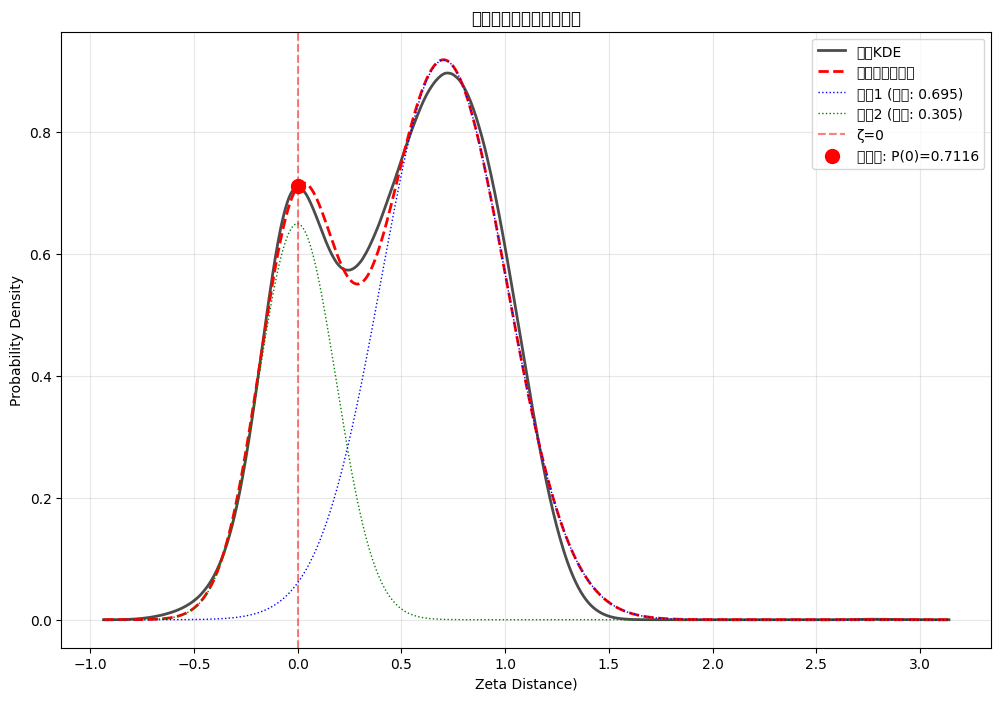

In [20]:
plot_results(x, smoothed_kde, estimated_params, zeta_zero_density)